In [1]:
from tqdm.notebook import tqdm
from nltk import sent_tokenize
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import sys
sys.path.append('../..')

from src import *
from src.test_utils import * 

torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

In [2]:
gritlm = GritLM("GritLM/GritLM-7B", device_map="cuda:2", torch_dtype="auto")
retriever = Retriever()
# llm = LLM()
llm = 'mistralai/Mistral-7B-Instruct-v0.2'
# llm = None

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Created GritLM: torch.bfloat16 dtype, mean pool, unified mode, bbcc attn


# Experiment

In [ ]:
dataset = NarrativeQADataset(llm)

In [3]:
dataset = QualityDataset(llm, split='dev')

In [ ]:
reading_agent = ReadingAgent(dataset, llm)

## Index passages

In [ ]:
longdoc = LongDoc(retriever, llm)

In [ ]:
paragraphs = ['\n'.join(p) for p in read_json(os.path.join(dataset.data_dir, f'pages_{1}.json'))]

In [ ]:
results = [ChunkInfo(**ci) for ci in read_json(os.path.join(dataset.data_dir, f'index_w_2_{1}.json'))]

## DPR

In [4]:
def split_sents(retriever_tokenizer:AutoTokenizer, p_input_ids:np.ndarray, is_contriever:bool):
    sents = sent_tokenize(retriever_tokenizer.decode(p_input_ids[1:-1] if is_contriever else p_input_ids))
    sent_lens = [len(retriever_tokenizer.encode(sent)) - 2 for sent in sents]
    sent_start = 1 if is_contriever else 0
    sent_spans = []
    for sid in range(len(sents)):
        sent_end = sent_start + sent_lens[sid]
        while len(retriever_tokenizer.decode(p_input_ids[sent_start:sent_end]).strip()) < len(sents[sid]):
            sent_end += 1
        sent_spans.append((sent_start, sent_end))
        sent_start = sent_end
    return sent_spans

def important_page_tokens(retriever_tokenizer:AutoTokenizer, question:str, pages, q_lhs:np.ndarray, q_input_ids:np.ndarray, q_emb, p_lhs, p_input_ids, pids, scores):
    print(question)
    for i in range(q_lhs.shape[0]):
        print(retriever_tokenizer.decode(q_input_ids[i]), np.linalg.norm(q_lhs[i]))
    print('\n')
    for rank, (pid, score) in enumerate(zip(pids, scores)):
        print(f'Rank {rank}\nPassage {pid}:\n{score}\n')
        print(pages[pid])
        token_scores = p_lhs[pid].dot(q_emb)
        max_indices = np.argsort(token_scores)[::-1][:(token_scores>2).sum()].tolist()
        print('\n\nHigh scored spans:\n')
        for idx in max_indices:
            print(token_scores[idx], f'<{retriever_tokenizer.decode(p_input_ids[pid][max(0, idx - 1): idx + 1])}>', retriever_tokenizer.decode(p_input_ids[pid][max(0, idx - 5): idx + 5]))
        print('\n\n')
        

import matplotlib.pyplot as plt
from typing import List, Tuple

def query_indicatiors(retriever_tokenizer:AutoTokenizer, question:str, pages, q_lhs:np.ndarray, q_input_ids:np.ndarray, p_lhs, p_input_ids, pids, scores, top_k:int=None, q_spans:List[Tuple[int, int]]=None):
    print(question)
    x = []
    if q_spans:
        new_q_lhs = []
        for sid, span in enumerate(q_spans):
            span_lhs = q_lhs[span[0] : span[1]].mean(axis=0)
            new_q_lhs.append(span_lhs)
            token = retriever_tokenizer.decode(q_input_ids[span[0] : span[1]])
            print(token, np.linalg.norm(span_lhs))
            x.append(f'{token}_{sid}')
        q_lhs = np.vstack(new_q_lhs)
    else:
        for tid, t in enumerate(q_input_ids):
            token = retriever_tokenizer.decode(t)
            print(token, np.linalg.norm(q_lhs[tid]))
            x.append(f'{token}_{tid}')
        
    print('\n')
    for pid, score in zip(pids, scores):
        print(f'{pid}: {score}')
    for rank, (pid, score) in enumerate(zip(pids, scores)):
        q_token_scores = np.matmul(q_lhs, p_lhs[pid].T)
        y = [np.sort(token_scores)[::-1][:top_k].mean() for token_scores in q_token_scores]
        y.reverse()
        plt.barh(list(reversed(x)), y)
        for tid, score in enumerate(y):
            plt.text(score, tid, str(score)[:4])
        plt.show()
        print(f'Rank {rank}\nPassage {pid}:\n{score}\n')
        print(pages[pid])
        print('\n\nHigh scored spans:\n')
        for q_token, token_scores in zip(x, q_token_scores):
            max_indices = np.argsort(token_scores)[::-1].tolist()[:10]
            print(np.sort(token_scores)[::-1][:top_k].mean(), f'<{q_token}>', *[(token_scores[idx], f'<{retriever_tokenizer.decode(p_input_ids[pid][max(0, idx - 5): idx + 1])}>') for idx in max_indices])
        print('\n\n')
        
def query_indicator_sents(retriever_tokenizer:AutoTokenizer, pages, q_lhs:np.ndarray, q_input_ids:np.ndarray, p_lhs, p_input_ids, test_pid, test_q_token_id:int, is_contriever:bool):
    print(retriever_tokenizer.decode(q_input_ids[test_q_token_id]), '\n')
    print(pages[test_pid], '\n')
    sent_spans = split_sents(retriever_tokenizer, p_input_ids[test_pid], is_contriever)
    scores = p_lhs[test_pid].dot(q_lhs[test_q_token_id])
    sent_scores = [(scores[sent_span[0]:sent_span[1]].mean(), retriever_tokenizer.decode(p_input_ids[test_pid][sent_span[0]:sent_span[1]])) for sent_span in sent_spans]
    sent_scores.sort(key=lambda x: x[0], reverse=True)
    for score, sent in sent_scores:
        print(score, sent)
        
def decode_span(input_ids:List[int], tokenizer:AutoTokenizer, spans:List[Tuple[int, int]]):
    return [tokenizer.decode(input_ids[w_span[0] : w_span[1]]) for w_span in spans]

def word_split(input_ids:List[int], tokenizer:AutoTokenizer):
    words:List[str] = word_tokenize(tokenizer.decode(input_ids))
    wid = 0
    w_spans = []
    temp_w_span = []
    w_start = 0
    for tid, input_id in enumerate(input_ids):
        temp_w_span.append(input_id)
        if tokenizer.decode(temp_w_span) == words[wid]:
            w_spans.append([w_start, tid + 1])
            temp_w_span = []
            w_start = tid + 1
            wid += 1
    return w_spans

In [4]:
test_i = 2
results = [ChunkInfo(**ci) for ci in read_json(os.path.join(dataset.data_dir, f'index_w_2_{test_i}.json'))]
pages = [ci.passage for ci in results]
questions, answers = dataset.get_questions_and_answers(dataset.data[test_i])
questions = [q.splitlines()[0] for q in questions]
questions

['What is the most likely meaning of the slang O.Q.? (in twentieth-century American English)',
 'Why does the Skipper stop abruptly after he says "when you\'re running a blockade"?',
 'Who or what is Leo?',
 'Why does the Skipper allow the new chef to use the heat-cannon as an incinerator?',
 ' Lieutenant Dugan brings up the examples of "High G" Gordon and "Runt" Hake in order to illustrates that...',
 "Why didn't the Skipper follow the new cook's advice about avoiding Vesta?",
 'Why was the new cook so upset that the Skipper decided to surrender?',
 'What does the Skipper mean by "lady-logic"?',
 "What would've happened if the new cook had told the Skipper about the ekalastron deposits earlier?"]

In [6]:
qid = 8
print(questions[qid])

What would've happened if the new cook had told the Skipper about the ekalastron deposits earlier?


### Contriever

In [ ]:
q_embedding = retriever.embed_paragraphs([questions[qid]], normalize=True, complete_return=True)
page_embeddings = retriever.embed_paragraphs(pages, normalize=True, complete_return=True)
c_q_emb, c_q_input_ids, c_q_lhs = q_embedding.embeddings, q_embedding.input_ids, q_embedding.last_hidden_states
c_p_emb, c_p_input_ids, c_p_lhs = page_embeddings.embeddings, page_embeddings.input_ids, page_embeddings.last_hidden_states
c_retriever_tokenizer = retriever.retriever_tokenizer
c_pids, c_scores = retriever.dense_retrieval(c_q_emb, c_p_emb, 10, normalize=False, return_score=True)

In [ ]:
important_page_tokens(c_retriever_tokenizer, questions[qid], pages, c_q_lhs[0], c_q_input_ids[0], c_q_emb[0], c_p_lhs, c_p_input_ids, c_pids, c_scores)

In [ ]:
query_indicatiors(c_retriever_tokenizer, questions[qid], pages, c_q_lhs[0], c_q_input_ids[0], c_p_lhs, c_p_input_ids, c_pids, c_scores)

In [ ]:
test_q_token_id = 15
test_pid = 4
query_indicator_sents(c_retriever_tokenizer, pages, c_q_lhs[0], c_q_input_ids[0], c_p_lhs, c_p_input_ids, test_pid, test_q_token_id, True)

### GritLM

In [ ]:
g_p_emb, g_p_input_ids, g_p_lhs = gritlm.encode(pages, max_length=8192)

In [7]:
g_p_emb, g_p_input_ids, g_p_lhs = gritlm.encode(pages, instructions=[LongDocPrompt.embed_w_note(ci.recap_str) for ci in results], max_length=8192)

In [8]:
g_q_emb, g_q_input_ids, g_q_lhs = gritlm.encode([questions[qid]], instructions=["Retrieve relevant passages from a story to answer a given question."])
g_retriever_tokenizer = gritlm.tokenizer
g_pids, g_scores = retriever.dense_retrieval(g_q_emb, g_p_emb, 10, normalize=False, return_score=True)

In [ ]:
important_page_tokens(g_retriever_tokenizer, questions[qid], pages, g_q_lhs[0], g_q_input_ids[0], g_q_emb[0], g_p_lhs, g_p_input_ids, g_pids, g_scores)

In [9]:
q_spans = word_split(g_q_input_ids[0], g_retriever_tokenizer)

What would've happened if the new cook had told the Skipper about the ekalastron deposits earlier?
What 1.2625158
would 1.2554008
' 1.2496248
ve 1.2685215
happened 1.2635761
if 1.2768614
the 1.2586445
new 1.2501462
cook 1.2650429
had 1.2824292
told 1.26327
the 1.2561252
Skip 1.2436008
per 1.262247
about 1.2621309
the 1.2639104
e 1.2480392
kal 1.2560611
astr 1.2661349
on 1.2451359
depos 1.2558019
its 1.2559724
earlier 1.2491302
? 1.2707921


10: 0.35269030928611755
6: 0.3492780029773712
3: 0.34279757738113403
2: 0.33834755420684814
11: 0.335380494594574
7: 0.3315945863723755
9: 0.32726553082466125
5: 0.3251521587371826
0: 0.3183150887489319
13: 0.31118449568748474


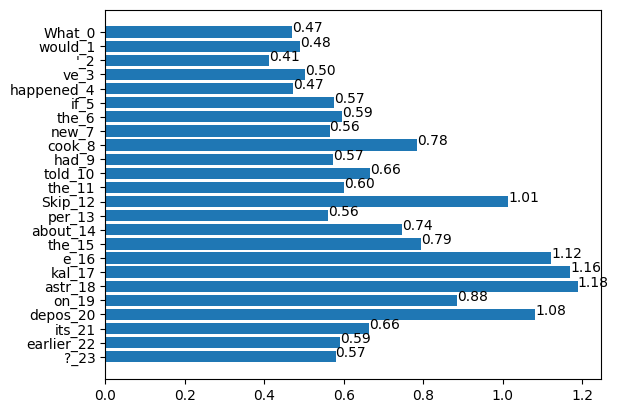

Rank 0
Passage 10:
0.4704573154449463

 "And for that," chuckled the Old Man, "Hooray! Pass them pancakes, son. Maybe now you'll stop shooting off about how we ought to of gone by way of Iris. Mmmm! Good!" 
 "Thank you, sir," said Slops mechanically. "But you realize there is extreme danger of encountering enemy ships?" 
 "Keep your pants on, Slops!" 
 "Eh?" The chef looked startled. "Beg pardon, sir?" 
 "I said keep your pants on. Sure, I know. And I've took precautions. There's a double watch on duty, and men at every gun. If we do meet up with an Alliance craft, it'll be just too bad for them! 
 "Yes, sirree!" The Old Man grinned comfortably. "I almost hope we do bump into one. After we burn it out of the void we'll have clear sailing all the way to Callisto." 
 "But—but if there should be more than one, sir?" 
 "Don't be ridiculous, my boy. Why should there be?" 
 "Well, for one thing," wrangled our pint-sized cook, "because rich ekalastron deposits were recently discovered on Vest

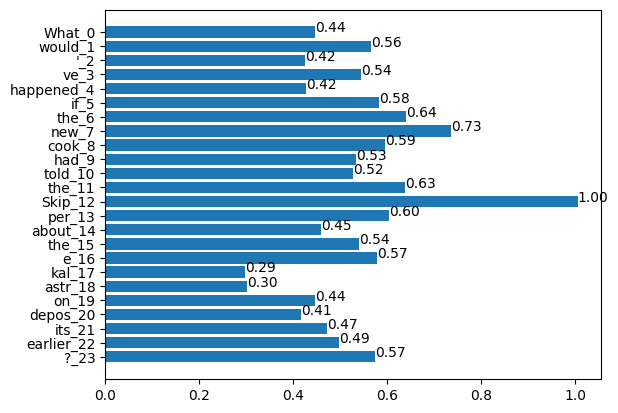

Rank 1
Passage 6:
0.4459044635295868

 Our little chef's face fell. "Now, that's too bad," he said discouragedly. "I was planning a special banquet for tomorrow, with roast marsh-duck and all the fixings, pinberry pie—but, oh, well!—if I have no incinerator—" 
 The skipper's eyes bulged, and he drooled like a pup at a barbeque. He was a bit of a sybarite, was Captain David O'Hara; if there was anything he dearly loved to exercise his molars on it was Venusian marsh-duck topped with a dessert of Martian pinberry pie. He said: 
 "We-e-ell, now, Mr. Dugan, let's not be too technical. After all, that rule was put in the book only to prevent persons which shouldn't ought to do so from having control of ordnance. But that isn't what Slops wants the cannon for, is it, son? So I don't see any harm in rigging up the old Nolan in the galley for incineration purposes. Did you say all the fixings, Slops?" 
 Maybe I was mistaken, but for a moment I suspected I caught a queer glint in our little che

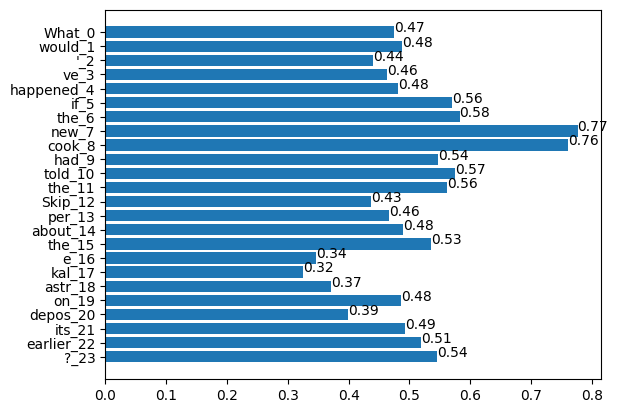

Rank 2
Passage 3:
0.4743390679359436

 "If I were you," interrupted our diminutive new chef thoughtfully, "I'd try to broach the blockade off Iris rather than Vesta. For one thing, their patrol line will be thinner there; for another, you can come in through the Meteor Bog, using it as a cover." 
 " Mr. Dugan! " 
 The Old Man's voice had an ominous ring to it, one I had seldom heard. I sprang to attention and saluted smartly. "Aye, sir?" 
 "Take this—this culinary tactician out of my sight before I forget I'm an officer and a gentleman. And tell him that when I want advice I'll come down to the galley for it!" 
 A hurt look crept into the youngster's eyes. Slowly he turned and followed me from the turret, down the ramp, and into the pan-lined cubicle which was his proper headquarters. When I was turning to leave he said apologetically, "I didn't mean any harm, Mr. Dugan. I was just trying to help." 
 "You must learn not to speak out of turn, youngster," I told him sternly. "The Old Man

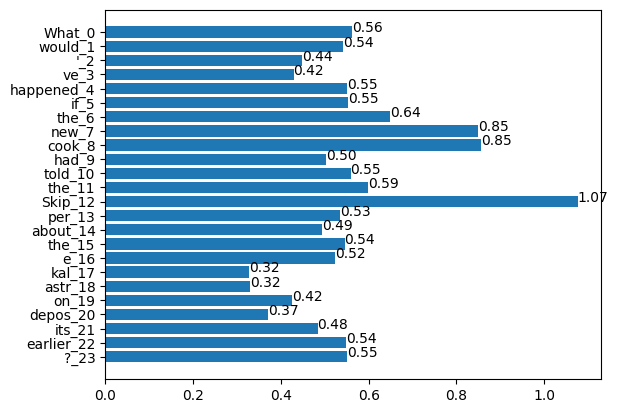

Rank 3
Passage 2:
0.5619563460350037

 The Old Man stared. 
 "W-who," he demanded dazedly, "might you be?" 
 "I might be," retorted the little stranger, "lots of people. But I came here to be your new cook." 
 O'Hara said, "The new—What's your name, mister?" 
 "Andy," replied the newcomer. "Andy Laney." 
 The Old Man's lip curled speculatively. "Well, Andy Laney," he said, "you don't look like much of a cook to me ." 
 But the little mugg just returned the Old Man's gaze coolly. "Which makes it even," he retorted. " You don't look like much of a skipper to me . Do I get the job, or don't I?" 
 The captain's grin faded, and his jowls turned pink. I stepped forward hastily. I said, "Excuse me, sir, shall I handle this?" Then, because the skipper was still struggling for words: "You," I said to the little fellow, "are a cook?" 
 "One of the best!" he claimed complacently. 
 "You're willing to sign for a blind journey?" 
 "Would I be here," he countered, "if I weren't?" 
 "And you have you

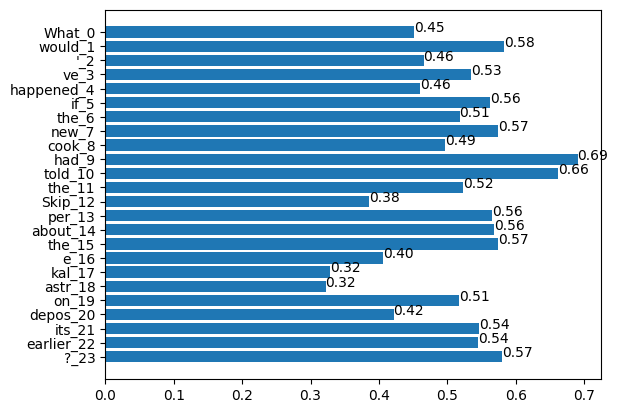

Rank 4
Passage 11:
0.4515402913093567

 "Don't give me lady-logic, you dope!" roared the Old Man, an enraged lion now, his breakfast completely forgotten. "Give me a sensible answer! If you'd told me that instead of just yipping and yapping about how via Iris was a nicer route I'd have listened to you! As it is, we're blasting smack-dab into the face of danger. And us on the most vital mission of the whole ding-busted war!" 
 He was out of his seat, bustling to the audio, buzzing Lieutenant Wainwright on the bridge. 
 "Johnny—that you? Listen, change traj quick! Set a new course through the Belt by way of Iris and the Bog, and hurry up, because—" 


High scored spans:

0.4515403 <What_0> (0.4515403, '<was a nicer route I>') (0.4514573, "<you'd told me that>") (0.42786017, '<\n "Johnny—that>') (0.41476154, '<d have listened to you!>') (0.40738747, "<nicer route I'd>") (0.39679128, "<'d have listened to you>") (0.3865123, '<his breakfast completely forgotten. ">') (0.38481343, '<ris and 

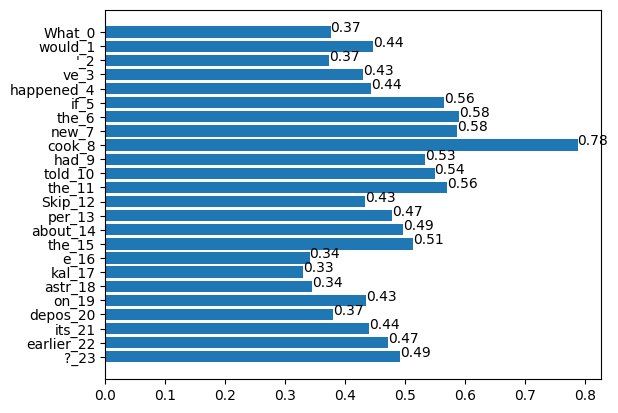

Rank 5
Passage 7:
0.37553155422210693

 I had finished my inspection, and I sniggered as his words reminded me of a joke I'd heard at a spacemans' smoker. 
 "Speaking of being careful, did you hear the giggler about the old maid at the Martian baths? Well, it seems this perennial spinster wandered, by accident, into the men's shower room and met up with a brawny young prospector—" 
 Captain Slops said, "Er—excuse me, Lieutenant, but I have to get this marsh-duck stuffed." 
 "Plenty of time, Slops. Wait till you hear this; it will kill you. The old maid got flustered and said, 'Oh, I'm sorry! I must be in the wrong compartment—'" 
 "If you don't mind, Mr. Dugan," interrupted the cook loudly, "I'm awfully busy. I don't have any time for—" 
 "The prospector looked her over carefully for a couple of seconds; then answered, 'That's O.Q. by me, sister. I won't—'" 
 "I—I've got to go now, Lieutenant," shouted Slops. "Just remembered something I've got to get from stores." And without even wai

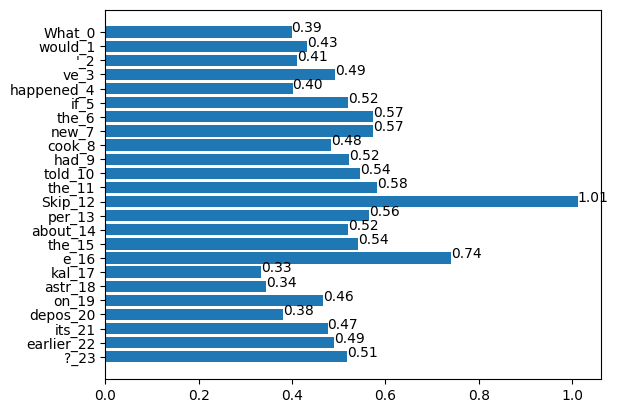

Rank 6
Passage 9:
0.39903461933135986

 He was an inveterate prowler. He snooped everywhere and anywhere from ballast-bins to bunk-rooms. He quizzed the Chief about engine-room practices, the gunner's mate on problems of ballistics, even the cabin-boy on matters of supplies and distribution of same. He was not only an asker; he was a teller, as well. More than once during the next nine days he forced on the skipper the same gratuitous advice which before had enraged the Old Man. By sheer perseverance he earned the title I had tagged him with: "Captain Slops." 
 I was willing to give him another title, too—Captain Chaos. God knows he created enough of it! 
 "It's a mistake to broach the blockade at Vesta," he argued over and over again. 
 "O.Q., Slops," the skipper would nod agreeably, with his mouth full of some temper-softening tidbit, "you're right and I'm wrong, as you usually are. But I'm in command of the Leo , and you ain't. Now, run along like a good lad and bring me some more o

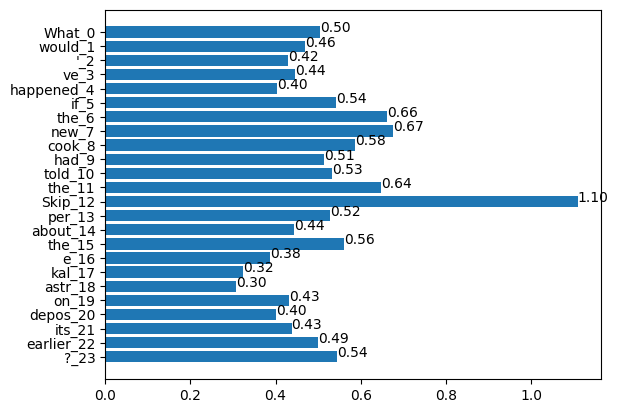

Rank 7
Passage 5:
0.5050628185272217

 "Captain Slops" blushed like a stereo-struck school-gal, and fidgeted from one foot to another. 
 "Oh, thank you, sir! Thank you very much. Yes, the galley was in fine order. That is—" He hesitated—"there is one little thing, sir." 
 "So? Well, speak up, son, what is it? I'll get it fixed for you right away." The Old Man smiled archly. "Must have everything shipshape for a tip-top chef, what?" 
 The young hash-slinger still hesitated bashfully. 
 "But it's such a little thing, sir, I almost hate to bother you with it." 
 "No trouble at all. Just say the word." 
 "Well, sir," confessed Slops reluctantly, "I need an incinerator in the galley. The garbage-disposal system in there now is old-fashioned, inconvenient and unsanitary. You see, I have to carry the waste down two levels to the rocket-chamber in order to expel it." 
 The skipper's brow creased. 
 "I'm sorry, Slops," he said, "but I don't see how we can do anything about that. Not just now, a

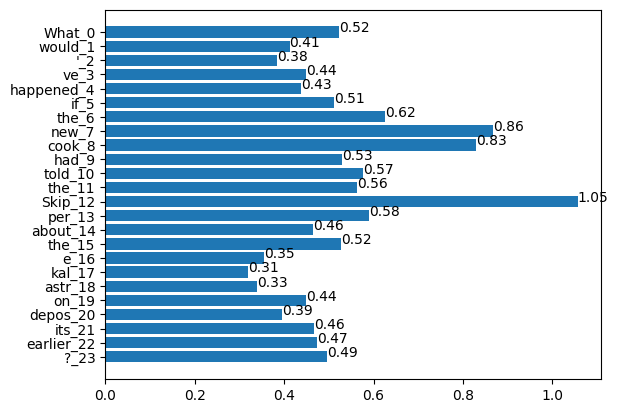

Rank 8
Passage 0:
0.5227383375167847

CAPTAIN CHAOS By NELSON S. BOND The Callisto-bound Leo needed a cook. What it got was a piping-voiced Jonah who jinxed it straight into Chaos. 
 [Transcriber's Note: This etext was produced from Planet Stories Summer 1942. Extensive research did not uncover any evidence that the U.S. copyright on this publication was renewed.] We picked up our new cook on Phobos. Not Phoebus or Phoebe; I mean Phobos, Mars' inner moon. Our regular victual mangler came down with acute indigestion—tasted some of his own cooking, no doubt—when we were just one blast of a jet-tube out of Sand City spaceport. But since we were rocketing under sealed orders, we couldn't turn back. 
 So we laid the Leo down on Phobos' tiny cradle-field and bundled our ailing grub-hurler off to a hospital, and the skipper said to me, "Mister Dugan," he said, "go out and find us a cook!" 
 "Aye, sir!" I said, and went. 
 Only it wasn't that easy. In those days, Phobos had only a handful of s

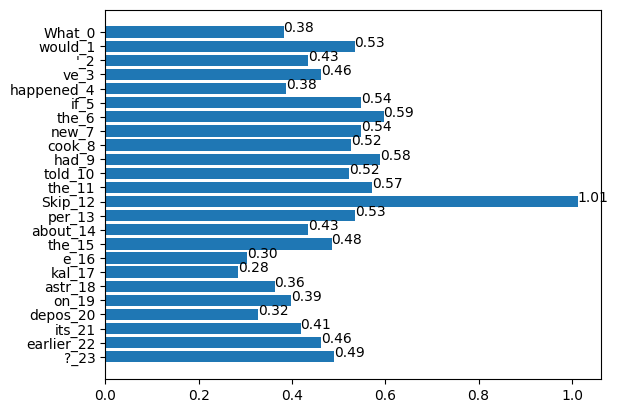

Rank 9
Passage 13:
0.38208138942718506

 "Stand by to admit a boarding party, Captain. It is futile to resist. You are surrounded by six armed craft, and your vessel is locked in our tensiles. Any further effort to make combat will bring about your immediate destruction!" 
 From the bridge, topside, snarled Johnny Wainwright, "The hell with 'em, Skipper! Let's fight it out!" And elsewhere on the Leo angry voices echoed the same defi. Never in my life had I felt such a heart-warming love for and pride in my companions as at that tense moment. But the Old Man shook his head, and his eyes were glistening. 
 "It's no use," he moaned strickenly, more to himself than to me. "I can't sacrifice brave men in a useless cause, Dugan. I've got to—" He faced the audio squarely. To the enemy commander he said, "Very good, sir! In accordance with the Rules of War, I surrender into your hands!" 
 The firing ceased, and a stillness like that of death blanketed the Leo . 
 It was then that Andy Laney, w

In [10]:
query_indicatiors(g_retriever_tokenizer, questions[qid], pages, g_q_lhs[0], g_q_input_ids[0], g_p_lhs, g_p_input_ids, g_pids, g_scores, 1)#, q_spans=q_spans)

In [ ]:
test_q_token_id = 15
test_pid = 4
query_indicator_sents(g_retriever_tokenizer, pages, g_q_lhs[0], g_q_input_ids[0], g_p_lhs, g_p_input_ids, test_pid, test_q_token_id, False)

In [ ]:
results[11].summary

In [ ]:
print(results[11].passage)

In [ ]:
results[11].print()

In [11]:
results[1].print()

Recap:
Passage -1:
Entity descriptions:
Leo: a Callisto-bound patrol ship in need of a cook
Summary:
 The Leo needed a cook on Callisto. We found one on Phobos but our previous cook fell ill. Despite Phobos having few settlers and a war with the Outer Planets, I struggled to find a replacement. I approached restaurants, employment agencies, hotels, tourist homes, and even joy-joints, but came up empty. I broadcasted a plea to the wealthy Phobosian colonists, but received no response. I returned to the ship and informed the captain we couldn't find a cook. He revealed he had read our sealed orders, which mentioned the blockade.


Passage:
 "We are to attempt to run the Outer Planets Alliance blockade at any spot which reconnaisance determines as favorable. Our objective is Jupiter's fourth satellite, Callisto. The Solar Federation Intelligence Department has learned of a loyalist uprising on that moon. It is reported that Callisto is weary of the war, with a little prompting will secede

## Find entities

In [5]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [7]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7f6fa798f170>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7f6fa798f290>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7f6fc88a1c40>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7f6fa78d9b10>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7f6fa771bc50>)]

In [31]:
from sklearn.cluster import DBSCAN

ent_candidates_all = list()
ent_candidates_pid = list()
for pid, ci in enumerate(results):
    doc = nlp(ci.passage)
    ncs = [nc for nc in doc.noun_chunks if nc.root.pos_ not in ['NUM', 'PRON']]
    ents = [ent for ent in doc.ents if ent.root.pos_ not in ['NUM', 'PRON']]
    ncs_spans = [(nc.start, nc.end) for nc in ncs]
    ents_spans = [(ent.start, ent.end) for ent in ents]
    spans = set(ncs_spans + ents_spans)
    ent_candidates = [doc[span[0]:span[1]].text for span in spans]
    ent_candidates_all.extend(ent_candidates)
    ent_candidates_pid.extend([pid] * len(ent_candidates))
ent_candidates_all_emb = retriever.embed_paragraphs(ent_candidates_all)
db = DBSCAN(eps=0.3, min_samples=3, metric="cosine").fit(ent_candidates_all_emb)
for ci

In [34]:
db.labels_

array([ 0, -1,  1, -1, -1, -1, -1,  2, -1, -1, -1,  3, -1, -1,  4, -1, 30,
       -1, -1, -1,  0,  5,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  6,  7,
       -1,  6,  2,  3,  8,  9, -1, -1,  1, -1, -1, -1, -1, -1, -1, 10, -1,
       11, -1, -1, -1, 12, -1, -1, -1,  3, -1, -1, 13, -1,  1, -1, -1, 12,
        0, 10, -1, -1, 12, -1, -1, -1, -1, -1, -1, -1, -1,  2, -1, -1, -1,
       12, -1, 14, -1, -1, -1, -1,  1, 10, 11,  0,  4, -1, -1, 11, -1, -1,
       -1, -1, -1, -1,  1, -1, 15,  7, -1, -1, 16,  5, 17, -1, -1, -1, -1,
        6, -1, 18, -1, -1, -1, -1, -1, 19, -1, -1, -1, -1, 15, -1, 20, 21,
       -1, -1, -1, -1, -1,  6, -1, 12, -1, -1, -1,  6, -1, -1, 51, -1, -1,
       -1, -1, -1, -1, 19, -1, -1, -1, -1,  3, 21,  3,  6, -1, -1, -1, -1,
       -1, -1, 15, -1, 20, -1, 10, 22,  5, 10, -1, -1, 12, -1, -1, -1, 23,
       -1, -1, -1, 24, -1, -1, 25, -1, -1, -1, -1, -1, 26, 23, 25, -1, 27,
       28, 10, 27, -1, -1, 28, 16, 10,  6, -1, -1, 10,  1, 26, 27,  6,  5,
       22,  5, -1, -1, 18

In [36]:
len(set(db.labels_))

53

In [37]:
ent_class = defaultdict(list)
for label, ent in zip(db.labels_, ent_candidates_all):
    if label >= 0:
        ent_class[label].append(ent)

In [39]:
for k, v in ent_class.items():
    print(k, v)

0 ['Phobos', "Phobos' tiny cradle-field", 'Phobos', 'Phobos', 'Phobos']
1 ['Dugan', 'Dugan', 'Dugan', 'Thanks, Dugan', 'Mister Dugan', 'Dugan', 'Dugan', 'Mr. Dugan', 'Mr. Dugan', 'Dugan', 'Dugan', 'Dugan', 'Dugan', 'Mr. Dugan', 'Dugan']
2 ['Sand City', 'Sand City', 'Sand City spaceport', 'Sand City']
3 ["Mars' inner moon", 'Mars', 'the Outer Planets', 'Outer Planets Alliance', 'the Outer Planets Alliance blockade', 'Martian', 'Mars', 'Martian', 'the Martian baths']
4 [', Lieutenant', 'CAPTAIN', 'Captain', 'the captain', 'Captain']
30 ['the tongue', 'eyes', 'his jaw', 'my nose', 'his nose', 'his mouth', 'his eyes', 'his head', 'His jaw', 'my tongue']
5 ['The Old Man', 'the Old Man', "The Old Man's lip", ' The Old Man', "the Old Man's gaze", 'the Old Man', "The Old Man's voice", 'the Old Man', "The Old Man's", 'Even the Old Man', 'The Old Man', 'The Old Man', 'the Old Man', 'The Old Man', 'the Old Man', 'the Old Man', 'The Old Man', 'the Old Man']
6 ['The blockade', 'the blockade', 'the 

In [6]:
doc = nlp(results[0].passage)

In [17]:
results[0].print()

Recap:


Passage:
CAPTAIN CHAOS By NELSON S. BOND The Callisto-bound Leo needed a cook. What it got was a piping-voiced Jonah who jinxed it straight into Chaos. 
 [Transcriber's Note: This etext was produced from Planet Stories Summer 1942. Extensive research did not uncover any evidence that the U.S. copyright on this publication was renewed.] We picked up our new cook on Phobos. Not Phoebus or Phoebe; I mean Phobos, Mars' inner moon. Our regular victual mangler came down with acute indigestion—tasted some of his own cooking, no doubt—when we were just one blast of a jet-tube out of Sand City spaceport. But since we were rocketing under sealed orders, we couldn't turn back. 
 So we laid the Leo down on Phobos' tiny cradle-field and bundled our ailing grub-hurler off to a hospital, and the skipper said to me, "Mister Dugan," he said, "go out and find us a cook!" 
 "Aye, sir!" I said, and went. 
 Only it wasn't that easy. In those days, Phobos had only a handful of settlers, and most of

In [7]:
doc.ents

(Callisto,
 Leo,
 Jonah,
 Chaos,
 Planet Stories,
 U.S.,
 Phobos,
 Phoebus,
 Phoebe,
 Phobos,
 Mars,
 one,
 Sand City,
 Leo,
 Phobos,
 Dugan,
 those days,
 Phobos,
 the Outer Planets,
 one,
 one,
 two,
 Phobosian colonists,
 I.P.S.,
 Dugan,
 Skipper,
 Thanks, Dugan,
 O.Q.,
 four hours,
 Sand City,
 a few minutes ago)

In [18]:
doc.ents[28].root.pos_

'NOUN'

In [20]:
doc.ents[28][1].pos_

'NOUN'

In [9]:
doc

CAPTAIN CHAOS By NELSON S. BOND The Callisto-bound Leo needed a cook. What it got was a piping-voiced Jonah who jinxed it straight into Chaos. 
 [Transcriber's Note: This etext was produced from Planet Stories Summer 1942. Extensive research did not uncover any evidence that the U.S. copyright on this publication was renewed.] We picked up our new cook on Phobos. Not Phoebus or Phoebe; I mean Phobos, Mars' inner moon. Our regular victual mangler came down with acute indigestion—tasted some of his own cooking, no doubt—when we were just one blast of a jet-tube out of Sand City spaceport. But since we were rocketing under sealed orders, we couldn't turn back. 
 So we laid the Leo down on Phobos' tiny cradle-field and bundled our ailing grub-hurler off to a hospital, and the skipper said to me, "Mister Dugan," he said, "go out and find us a cook!" 
 "Aye, sir!" I said, and went. 
 Only it wasn't that easy. In those days, Phobos had only a handful of settlers, and most of them had good-pay

In [16]:
ncs = [nc for nc in doc.noun_chunks if nc.root.pos_ != 'PRON']
ncs

[CAPTAIN,
 NELSON S. BOND,
 The Callisto-bound Leo,
 a cook,
 a piping-voiced Jonah,
 Chaos,
 [Transcriber's Note,
 This etext,
 Planet Stories Summer,
 Extensive research,
 any evidence,
 the U.S. copyright,
 this publication,
 our new cook,
 Phobos,
 Not Phoebus,
 Phoebe,
 Mars' inner moon,
 Our regular victual mangler,
 acute indigestion,
 his own cooking,
 just one blast,
 a jet-tube,
 Sand City spaceport,
 sealed orders,
 the Leo,
 Phobos' tiny cradle-field,
 our ailing grub-hurler,
 a hospital,
 the skipper,
 Mister Dugan,
 "Aye,
 those days,
 Phobos,
 only a handful,
 settlers,
 good-paying jobs,
 war,
 the Outer Planets,
 no man,
 his right senses,
 a single-trip jump,
 a rickety old patrolship,
 nobody-knew-where,
 course,
 cooks,
 a hurry,
 petticoats,
 a nudist camp,
 the restaurants,
 the employment agencies,
 no dice,
 the hotels,
 the tourist homes,
 the cleaner-looking joy-joints,
 a blank,
 a plaintive appeal,
 the wealthy Phobosian colonists,
 the more patriotic sons,


In [21]:
ncs[34][2].pos_

'NOUN'